In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
training_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=data_transforms['train']
)

test_data = datasets.CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=data_transforms['val']
)

In [4]:
batch_size = 4
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

Show some training images

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

In [8]:
def show_image(img, one_channel=False):
    img = img / 2 + 0.5  # unnormalize
    numpy_img = img.numpy()
    if one_channel:
        plt.imshow(numpy_img, (1,2,0))
    else:
        plt.imshow(np.transpose(numpy_img, (1,2,0)))
    plt.show()

In [9]:
data_iteration = iter(train_loader)
images, labels = data_iteration.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


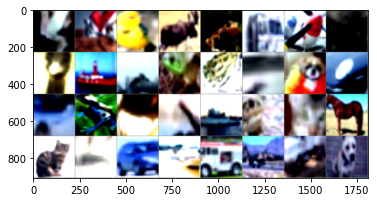

frog  cat   bird  deer 


In [10]:
show_image(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [24]:
class CIFARClf1(nn.Module):
    def __init__(self):
        super(CIFARClf1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.batchnorm2 = nn.BatchNorm2d(6)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.batchnorm3 = nn.BatchNorm2d(6)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
model1 = CIFARClf1().to(device)

In [26]:
model1

CIFARClf1(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)


In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 